# Clustering of Reddit Titles

Link to GitLab repo: [here](https://gitlab.datascience.aim.edu/mbargo/redditclusters/tree/master)

### Executive Summary

This work focuses on clustering the titles obtained from different subreddits. Data was pre-processed by converting everything to lowercase, removing the punctuation marks and doing lemmatization. The bag-of-words representation of the titles were obtained using tf-idf vectorization. Clustering was done using the non-negative matrix factorization of the document matrix.

Setting the number of clusters to 7 gave rise to the following topics: New Year, Sanders and Clinton, Game, TIL, Trump, Make, and Support. Setting the number of clusters to 12 gave rise to the following topics: New Year, Sanders, Game, TIL, Trump, Make, Support, Clinton, Need Help or Advice, Food, Question on Pay or Car, and Iowa.

### Introduction

Reddit is a social network (originating from the US) that allows news aggregation, content sharing and discussions. People connect even though they don't know each other, as long as they share the same interests. Reddit makes it very easy to find your circles of interests by organizing the discussions into subreddits, which cover a wide variety of topics such as news, science, movies, video games, etc.

The objective of this work is to look at the titles from the file `reddit-dmw-sample.txt` and attempt to classify these titles into subtopics or subreddits. These titles are extracted from https://www.reddit.com/ from various subreddits. We will do this by clustering, where we group similar titles on the fly instead of classifying them under pre-defined topics.

Clustering methods cannot be applied directly to the title list, so we would need to convert the data into matrix format before doing so. The following steps must be done before proceeding with clustering:

1. Data cleaning, which involves converting into lowercase (to prevent separate counting of say Begin and begin) and removal of punctuation marks. We will also do lemmatization, which involves removal of suffixes to generate word stems. This enables us to lump together words that have the same conceptual meaning (like make, making and made).
2. Data processing, with the end goal of converting the text data into its bag-of words representation. The bag-of-words vector of a title is a vector where each component corresponds to a unique word and the value corresponds to the count of each word in the text. This involves:
    * filtering, which allows us to limit the clustering problem by reducing the number of features that needed to be considered. For example, we can limit the problem so that we will only consider English titles.
    * removing stop words, which are very common but carry no information. Examples are pronouns, prepositions and conjunctions.
    * term weighting, which involves recalculate the weights of the words to reduce the effect of frequent terms having little information and highlight the rarer yet more interesting terms.

We will utilize the nonnegative matrix factorization method for clustering the reddit titles. This method has been shown to perform well on classifying documents compared with other clustering techniques. NMF approximately factors a matrix $V$ into two matrices, $V \approx WH$, so that the entries of $W$ and $H$ are nonnegative. Hence, we interpret an NMF decomposition of the bag-of-words matrix would yield components that could be considered “topics”, and decompose each document into a weighted sum of topics.


### Data Cleaning

We begin the data cleaning by opening the file to take a glimpse of the format and the contents of the file.

In [1]:
import pandas as pd
# Opening the file
df = pd.read_csv('reddit-dmw-sample.txt', sep='\t', header=0, index_col=0)
df.head()

author                                              title
0  PrimotechInc        7 Interesting Hidden Features of apple ios9
1    xvagabondx                    Need an advice on gaming laptop
2  nkindustries  Semi automatic ROPP Capping machine / ROPP Cap...
3     Philo1927  Microsoft Plumbs Ocean’s Depths to Test Underw...
4    tuyetnt171                OPPO F1 chính hãng - Fptshop.com.vn

The objective is to cluster the titles, so we will ignore the `author` column and extract the entries in the `title` column. We convert the column into a list (called `reddit_corpus`) and look at the initial set of titles.

In [2]:
from collections import Counter

# Build corpus from 'title' column
reddit_corpus = df['title'].tolist()
print(reddit_corpus)
print('Number of titles: ' + str(len(reddit_corpus)))

['7 Interesting Hidden Features of apple ios9', 'Need an advice on gaming laptop', 'Semi automatic ROPP Capping machine / ROPP Cap Sealing Machine', 'Microsoft Plumbs Ocean’s Depths to Test Underwater Data Center', 'OPPO F1 chính hãng - Fptshop.com.vn', 'Stewed Ramps w/ Fixings in Helvatia, WV', '(California) Is it a crime when a Religious figure/ Lecturer has relations with one of his followers', 'Being accused of public indecency, among other things. This is a misunderstanding because I had health issues. [Kansas, USA]', '[US-CA/NV] My parents have been separated for almost 20 years, my mom found out my dad divorced her without her knowledge a few years ago when I was about 14--can she claim backdated child support?', 'Skyrim Ps4?', 'TIL Maternal kisses are not effective in alleviating minor childhood injuries (boo-boos): a randomized, controlled and blinded study.', 'SF/NYC what is the best way to find a good startup lawyer?', 'LittleBigPlanet 3 Recreates Uncharted 4 Trailer', 'Char

We notice that there are foreign titles included in the list. We will limit the clustering procedure to English titles, so we extract these English titles from `reddit_corpus` and put them in `reddit_newcorpus`. The title will be excluded from the new list if more than 50 % of the words in the title are classified as non-English. The `nltk` library allows us to filter the English words from the list.

In [3]:
import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet

reddit_newcorpus = []
for title in reddit_corpus:
    title_words = title.split()
    title_length = len(title_words)
    notEnglish = 0
    for test_word in title_words:
        if not wordnet.synsets(test_word):
            notEnglish +=1
    if notEnglish <= 0.5*title_length:
        reddit_newcorpus.append(title.lower())

n_doc = len(reddit_newcorpus)
print(reddit_newcorpus)
print('Number of titles: ' + str(len(reddit_newcorpus)))

['7 interesting hidden features of apple ios9', 'need an advice on gaming laptop', 'semi automatic ropp capping machine / ropp cap sealing machine', 'microsoft plumbs ocean’s depths to test underwater data center', 'stewed ramps w/ fixings in helvatia, wv', '(california) is it a crime when a religious figure/ lecturer has relations with one of his followers', 'being accused of public indecency, among other things. this is a misunderstanding because i had health issues. [kansas, usa]', '[us-ca/nv] my parents have been separated for almost 20 years, my mom found out my dad divorced her without her knowledge a few years ago when i was about 14--can she claim backdated child support?', 'til maternal kisses are not effective in alleviating minor childhood injuries (boo-boos): a randomized, controlled and blinded study.', 'sf/nyc what is the best way to find a good startup lawyer?', 'littlebigplanet 3 recreates uncharted 4 trailer', 'charged with dui 2 years and 4 months after i was involved

We removing the punctuations from the titles and doing the process of lemmatization. We use `WordNetLemmatizer` from the `nltk.stem` library to lemmatize the verbs, nouns, adjectives and adverbs.

In [4]:
from nltk.stem import WordNetLemmatizer
import string

lemmer = WordNetLemmatizer()

lemmatized_reddit_corpus = []
for title in reddit_newcorpus:
    # Remove punctuation
    title = ''.join([i for i in title if i not in string.punctuation + '”' + '’' + '“'])
    # Lemmatization of verbs
    title = ' '.join([lemmer.lemmatize(word, pos='v')
                      for word in title.split(' ') if len(word) > 2])
    # Lemmatization of nouns
    title = ' '.join([lemmer.lemmatize(word, pos='n')
                      for word in title.split(' ') if len(word) > 2])
    # Lemmatization of adjectives
    title = ' '.join([lemmer.lemmatize(word, pos='a')
                      for word in title.split(' ') if len(word) > 2])
    # Lemmatization of adverbs
    title = ' '.join([lemmer.lemmatize(word, pos='r')
                      for word in title.split(' ') if len(word) > 2])
    lemmatized_reddit_corpus.append(title)

print(lemmatized_reddit_corpus)
print('Number of titles: ' + str(len(lemmatized_reddit_corpus)))

['interest hide feature apple ios9', 'need advice game laptop', 'semi automatic ropp cap machine ropp cap seal machine', 'microsoft plumb ocean depth test underwater data center', 'stew ramp fix helvatia', 'california crime when religious figure lecturer have relation with one his follower', 'accuse public indecency among other thing this misunderstand because have health issue kansa usa', 'uscanv parent have separate for almost year mom find out dad divorce her without her knowledge few year ago when about 14can she claim backdate child support', 'til maternal kiss not effective alleviate minor childhood injury booboos randomize control and blind study', 'sfnyc what the best way find good startup lawyer', 'littlebigplanet recreate uncharted trailer', 'charge with duo year and month after involve single car accident', 'new poll show how far hillary have fall with democrat', 'how cod kill your hope', 'test', 'appear that trump get nervous that work family catch that his policy represent

### Data Processing

We will now convert the list of processed titles `lemmatized_reddit_corpus` into its bag-of-words representation. We will be utilizing stop words, because these words are somewhat uninformative in representing the meaning of a title. For term weighting, we are going to use the tf–idf transform (term-frequency times inverse document-frequency transform), which is one of the most popular term-weighting schemes.

In the code snippet below, we use the `TfidfVectorizer` class. We will only use words with at least 3 characters in our vectorization, because those words with less than 2 characters are not so relevant in determining the topics. We will also drop the words that appear in less than 0.1% of the entire list.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(stop_words='english', min_df = 0.001,
                             token_pattern=r'[a-z]{3,}')
tfidf_v = vectorizer.fit_transform(lemmatized_reddit_corpus)
idx_to_word = np.array(vectorizer.get_feature_names())
tfidf_v = pd.DataFrame(tfidf_v.toarray(), columns=vectorizer.get_feature_names())
display(tfidf_v)

abandon  able  abortion  abuse  academy  accept  access  accident  \
0     0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
1     0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
2     0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
3     0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4     0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
5     0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
6     0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
7     0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
8     0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
9     0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
10    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
11    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.36589   
12    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
13    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
14    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
15    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
16    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
17    0.00000   0.0  0.593833    0.0      0.0     0.0     0.0   0.00000   
18    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
19    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
20    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
21    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
22    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
23    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
24    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
25    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
26    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
27    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
28    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
29    0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
...       ...   ...       ...    ...      ...     ...     ...       ...   
4865  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4866  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4867  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4868  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4869  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4870  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4871  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4872  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4873  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4874  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4875  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4876  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4877  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4878  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4879  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4880  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4881  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4882  0.47349   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4883  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4884  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4885  0.00000   0.0  0.000000    0.0      0.0     0.0     0.0   0.00000   
4886  0.00000   0.0  0.000000  

### Clustering: 7 Clusters

For the clustering method, we are going to use the non-negative matrix factorization (NMF) of the document matrix `tfidf_v`. We factor the document matrix into two matrices $WH$, where each row in $H$ is a component (the reddit titles in our test case), and each row in $W$   contains the weights of each component.

We first tried to guess the number of clusters that exist in our data. We initially tried to divide the data set into 7 clusters.

In [6]:
# NMF clustering
from sklearn import decomposition

n_topics = 7
model = decomposition.NMF( init="nndsvd", n_components=n_topics ) 
W = model.fit_transform(tfidf_v)
H = model.components_

We tried to get the top 20 words for every cluster to determine the theme of each cluster. We also plot the reverse cumulative histogram of the weights obtained for each topic cluster.

In [7]:
# print the topics
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ", ".join([str(x) for x in idx_to_word[topic.argsort()[-20:]]])))

Topic 1: drink, amaze, state, party, meal, friend, pizza, company, time, old, apple, start, resolution, homemade, york, eve, day, happy, year, new
Topic 2: candidate, tuesday, final, lead, voter, million, democratic, poll, state, super, say, vote, campaign, caucus, email, iowa, hillary, bernie, clinton, sander
Topic 3: enjoy, youtube, thing, advice, nintendo, bad, compare, awesome, look, great, good, time, just, steam, release, like, best, play, video, game
Topic 4: pay, time, actually, old, want, day, play, know, man, kill, war, star, unite, thing, woman, state, people, world, use, til
Topic 5: poll, tuesday, remove, john, white, say, oliver, just, black, student, supporter, endorse, inside, plan, clinton, defeat, iowa, rally, donald, trump
Topic 6: online, sure, english, homemade, great, healthy, perfect, dinner, friend, chicken, best, cake, time, easy, home, recipe, pizza, good, food, make
Topic 7: advice, computer, line, service, best, dell, dial, antivirus, need, toll, tollfree, f

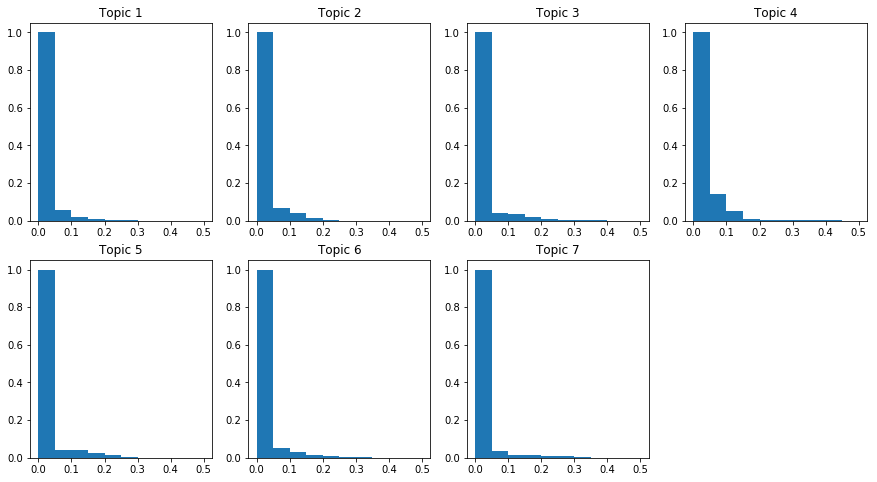

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 8.0)

plt.subplot(2, 4, 1)
plt.hist(W[:,0], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 1')

plt.subplot(2, 4, 2)
plt.hist(W[:,1], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 2')

plt.subplot(2, 4, 3)
plt.hist(W[:,2], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 3')

plt.subplot(2, 4, 4)
plt.hist(W[:,3], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 4')

plt.subplot(2, 4, 5)
plt.hist(W[:,4], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 5')

plt.subplot(2, 4, 6)
plt.hist(W[:,5], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 6')

plt.subplot(2, 4, 7)
plt.hist(W[:,6], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 7')

plt.show()

We extracted the reddit titles having weights greater than 0.05 for each topic. We decided to impose a limit on the weights because if the weight is lower, it is likely that the title is not related to the topic. Observe from the cumulative histograms above, there is a chance that we will be throwing away a lot of titles and leave them unclustered.

From the top 20 words, we can generally describe the titles based on the following themes:

**Topic 1: New (284 titles)**

In [9]:
top_indices1 = np.argsort(W[:,0])[::-1]
top_documents1 = []
topic1_str = ''
for doc_index in top_indices1[0:n_doc]:
    if W[doc_index,0] > 0.05:
        top_documents1.append(reddit_newcorpus[doc_index])
        topic1_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents1))
top_documents1

284


['new years ragdolls',
 'new years cupcakes',
 'to all those being alone on new years.... this is for you... you are not alone.',
 "new year's brunch. happy new year!",
 'happy new years everyone!',
 'happy new years',
 'happy new year',
 'happy new year foodies',
 'happy new year !',
 'happy new years',
 'happy new year r/gaming!!',
 "new year's day american-canookistaan peace poutine",
 "new year's day salmon nigiri [4528x2660]",
 'new yorker pastrami reuben sub from getgo',
 "a new year's eve fluffybeard vlog",
 'steaks for new years eve!',
 "i always said i'd do the in-game countdown for new year's one year. took me a little while...",
 'mehbooba mufti can become cm for three years, mufti mohammad sayeed is in icu',
 'first foraged ramps of the year.',
 'happy new year 2016 ....... cake for you',
 'happy new year with most amazing flame fire',
 'new years in city 17',
 'happy new year! drunkflex tournament starting (~18 people)',
 'happy new year everyone! what will be the first ga

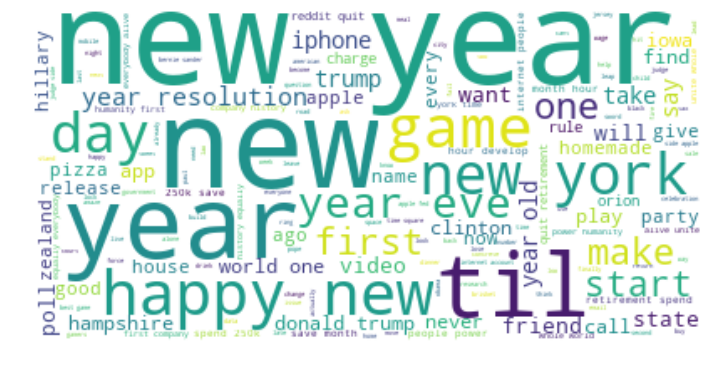

In [10]:
from wordcloud import WordCloud, ImageColorGenerator

plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic1_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Topic 2: Bernie Sanders, Hillary Clinton (338 titles)**

In [11]:
top_indices2 = np.argsort(W[:,1])[::-1]
top_documents2 = []
topic2_str = ''
for doc_index in top_indices2[0:n_doc]:
    if W[doc_index,1] > 0.05:
        top_documents2.append(reddit_newcorpus[doc_index])
        topic2_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents2))
top_documents2

338


['chomsky on sanders vs clinton',
 'behind bernie sanders: levi sanders posture',
 'hillary clinton leads bernie sanders 54%-24% in florida',
 'bernie sanders ‘revolution’ threatens hillary clinton in iowa.',
 "10 reasons i'm only voting for bernie sanders and will not support hillary clinton",
 'bernie sanders trounces hillary clinton at first super tuesday contest - in wellington',
 'bernie sanders trounces hillary clinton at first super tuesday contest - in wellington',
 'bernie sanders vs hillary clinton: the real differences',
 'bernie sanders vs hillary clinton: the real differences',
 'bernie sanders vs hillary clinton: the real differences',
 'bernie sanders made mistake not going after hillary clinton email scandal, critics say',
 'clinton, sanders neck and neck in iowa - barney frank talks about bernie sanders and wall street',
 'hillary clinton has already forgotten about bernie sanders | vice | united states',
 'in final iowa blitz, an outraged hillary clinton channels…bern

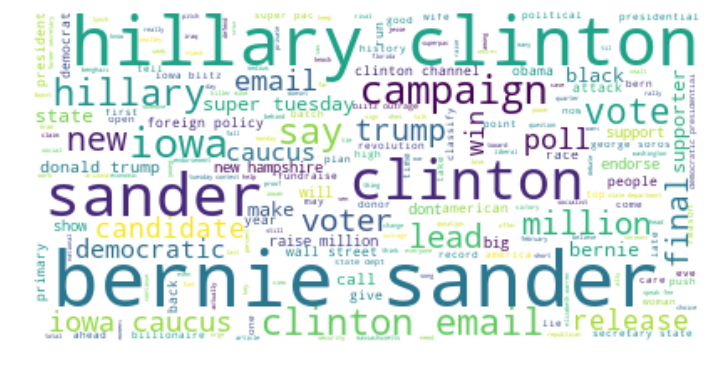

In [12]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic2_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Topic 3: Gaming (187 titles)**

In [13]:
top_indices3 = np.argsort(W[:,2])[::-1]
top_documents3 = []
topic3_str = ''
for doc_index in top_indices3[0:n_doc]:
    if W[doc_index,2] > 0.05:
        top_documents3.append(reddit_newcorpus[doc_index])
        topic3_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents3))
top_documents3

187


['abcya 20 games',
 'top 43 anticipated games of 2016',
 'retro gaming vs indie gaming',
 'spectator gaming',
 'abcya games - abcya 20 games',
 'do you find irritating that some games switch to day/night so quickly?',
 'gaming buddies',
 "a gaming addict's confession",
 'game vouchers for sony',
 'my ultimate gaming setup 2016!',
 'prvi game !? | game 1 - minecraft survival games',
 'megaman in his first game, compared to his last game',
 'poorly describe a game and have others guess which game it is.',
 'does the new game squad have a subreddit?',
 'my year in game screenshots #2',
 'my year in gaming screenshots',
 'what thing in a game instantly makes it a good game?',
 'til of a popular mind game simply known as "the game". the goal is to go as long as possible without thinking about the game; upon doing so, you announce out loud that you lost the game. everyone who hears about the game is said to be playing it.',
 'k-9! video gaming',
 'formerly addicted gamer: my 2016 resolution 

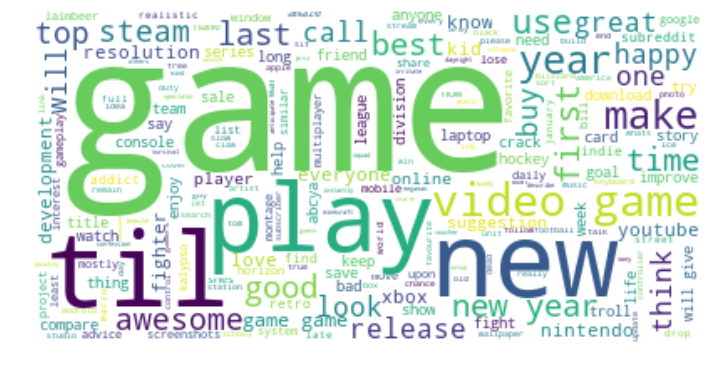

In [14]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic3_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Topic 4: TIL (Today I Learned) (700 titles)**

In [15]:
top_indices4 = np.argsort(W[:,3])[::-1]
top_documents4 = []
topic4_str = ''
for doc_index in top_indices4[0:n_doc]:
    if W[doc_index,3] > 0.05:
        top_documents4.append(reddit_newcorpus[doc_index])
        topic4_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents4))
top_documents4

700


['til that chimpanzees can identify other chimpanzees individually by seeing photographs of their butts',
 "til that don juan's last name is correctly pronounced as joo-an",
 'til mars has avalanches.',
 'til there is something called world passport',
 'til the gas gauge on my car has an arrow indicating which side to pump gas',
 'til 1 out of 10 women have inverted nipples.',
 'til freestyle canoeing was a thing',
 'til that one-way mirrors and two-way mirrors are the same thing',
 'til: there is a theory that the change in the musical scale from 432 hz to 440 hz was dictated by joseph goebbels.',
 'til president william mckinley was assassinated by an anarchist.',
 'til z is pronounced z in the us, but z in other countries',
 'til the united states is the worlds sole superpower.',
 "til that your brainstem forces you to lift your arms up once you've been knocked out. this is called the fencing response.",
 'til astronaut urine is a national treasure',
 'til firefighters in dubai are 

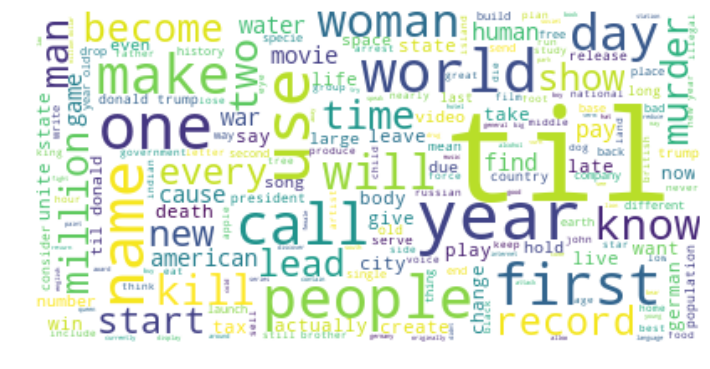

In [16]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic4_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Topic 5: Donald Trump (206 titles)**

In [17]:
top_indices5 = np.argsort(W[:,4])[::-1]
top_documents5 = []
topic5_str = ''
for doc_index in top_indices5[0:n_doc]:
    if W[doc_index,4] > 0.05:
        top_documents5.append(reddit_newcorpus[doc_index])
        topic5_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents5))
top_documents5

206


["you can't stump the trump volume xix (the foolish foam boi)",
 "donald trump's clinton gambit",
 "til trump's last name is trump",
 'donald trump jr. offers to buy airfare for celebs who would flee u.s. over prez trump',
 'kris kobach endorses donald trump',
 'even as he rises, donald trump entertains conspiracy theories',
 "donald trump's german roots",
 'how clinton is plotting to go after trump',
 'jerry falwell, jr. in iowa: trump has wendy’s, not caviar, on his plane',
 'photojournalist roughed up at donald trump rally in virginia',
 "donald trump's year of tweeting dangerously",
 'donald trump’s message resonates with white supremacists',
 'donald trump’s hollywood walk of fame star defaced with swastika',
 'would billionaire donald trump bankroll his own campaign?',
 'ny times: the clinton plan to defeat donald trump',
 'tucker carlson describing a voicemail left to him by donald trump in 2001: “it’s true you have better hair than i do,” trump said matter-of-factly. “but i get

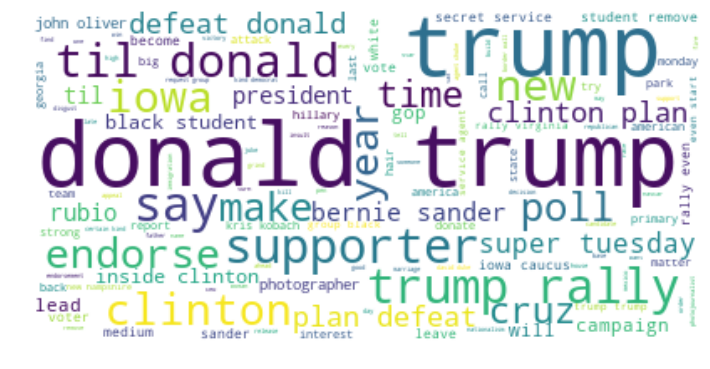

In [18]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic5_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Topic 6: Make (242 titles)**

In [19]:
top_indices6 = np.argsort(W[:,5])[::-1]
top_documents6 = []
topic6_str = ''
for doc_index in top_indices6[0:n_doc]:
    if W[doc_index,5] > 0.05:
        top_documents6.append(reddit_newcorpus[doc_index])
        topic6_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents6))
top_documents6

242


['i made some tuna croquettes',
 'i made this creme caramel',
 "i made reddit's snoo in saints row: the third",
 'so gamegate made me a pessimist',
 'my condenser mic making buzzing/ static noises',
 "i couldn't have made this horoscope up.",
 'paladin danse makes everyone weak in the knees',
 'made pumpkin pasties and butterbeer! wizard food!',
 'til that lamborghini makes tractors and then started making supercars',
 'i made crepes (and they were good!)',
 'home made lamb kibeh',
 'how to make easy foods 2016',
 "made my nephew's cake and cupcakes",
 'made some dinner!',
 'caster makes a point.',
 '9am lectures made survivable by 10am full english',
 'first time making creme brûlée! what do you think',
 'i made a cheeseburger and took a picture of it.',
 '8 tips for making the most badass belgian waffles',
 'what are some good foods i can make without an oven or toaster?',
 'how baby skiffs are made (borderlands 2)',
 'prosciutto pizza made with homemade flatbread',
 'i made focaccia

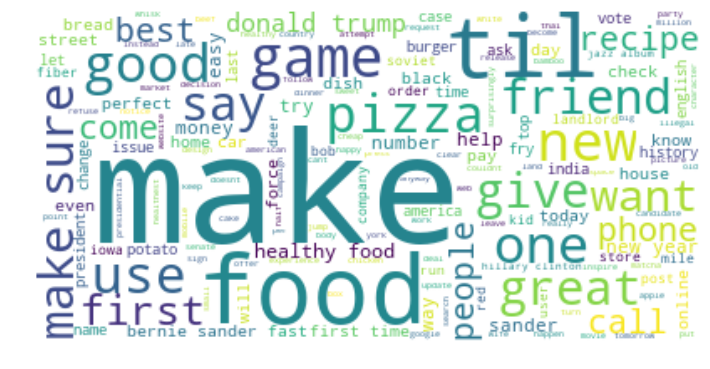

In [20]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic6_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Topic 7: Support (174 titles)**

In [21]:
top_indices7 = np.argsort(W[:,6])[::-1]
top_documents7 = []
topic7_str = ''
for doc_index in top_indices7[0:n_doc]:
    if W[doc_index,6] > 0.05:
        top_documents7.append(reddit_newcorpus[doc_index])
        topic7_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents7))
top_documents7

174


['essential aspects of cisco router toll free... - cisco router technical support phone number',
 'norton antivirus technical support phone number',
 'get best tech support call 1-877-788-9452 hotmail phone number',
 '1-877-523-3678 #@f-secure antivirus tech support phone number',
 '1-877-523-3678 #@f-secure antivirus tech support phone number',
 'hotmail support number 1-877-788-9452 tollfree to get tech support',
 'hotmail support number 1-877-788-9452 tollfree to get tech support',
 'hotmail support 1-877-788-9452 number tollfree to get tech support',
 'gmail technical support 1 800-748-0719 phone number',
 'why rogers technical support is a reliable... - rogers email technical support 1 888 467 5549 phone number',
 'online technical support phone number for dell tablet 1-800-749-0917',
 'call 1-877-788-9452 tollfree hotmail technical support number',
 'get instant email support call hotmail support number 1-877-788-9452 tollfree',
 'norton antivirus tech support phone number usa',


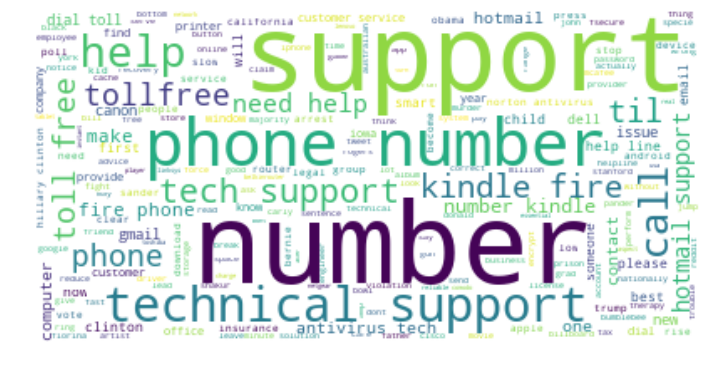

In [22]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic7_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We chose to impose the criteria that the weight should be greater than 0.05 to be included in a particular cluster. With this condition, it is quite possible for a particular title to be included in more than one cluster. This is acceptable because sometimes, people post topics on a certain subreddit that ends up being moved to another subreddit, because different people may have different opinions on the classification of a particular discussion thread.

It is also possible that some titles were not clustered since we only included titles that have a weight greater than 0.05. In the code below, determine the titles that were not included in any of the 7 clusters.

In [23]:
unclustered_ind = []
for ind in range(4895):
    if np.amax(W[ind,:]) <= 0.05:
        unclustered_ind.append(ind)
unclustered_titles = [reddit_newcorpus[i] for i in unclustered_ind]
print(len(unclustered_titles))
unclustered_titles

3021


['7 interesting hidden features of apple ios9',
 'semi automatic ropp capping machine / ropp cap sealing machine',
 'microsoft plumbs ocean’s depths to test underwater data center',
 'stewed ramps w/ fixings in helvatia, wv',
 '(california) is it a crime when a religious figure/ lecturer has relations with one of his followers',
 'being accused of public indecency, among other things. this is a misunderstanding because i had health issues. [kansas, usa]',
 'sf/nyc what is the best way to find a good startup lawyer?',
 'littlebigplanet 3 recreates uncharted 4 trailer',
 'charged with dui 2 years and 4 months after i was involved in a single car accident.',
 'how cod kills your hope',
 'test',
 "i'd like to buy the rights of a post on reddit to recreate in another medium. how do i create a legal contract for this between strangers online?",
 'kentucky senate oks requiring ultrasounds prior to abortions',
 'socialshare page 1',
 'aussie heroes steam group',
 "i know this isn't tr best pla

### Clustering: 12 Clusters

We try to increase the number of clusters to 12, to reduce the number of titles in the unclustered category. We also plot the cumulative histograms of the weights for each topic, to give us an idea on how many titles will be left unclustered.

Topic 1: time, internet, hampshire, drink, friend, party, amaze, meal, pizza, old, apple, start, resolution, homemade, york, eve, day, happy, year, new
Topic 2: american, february, endorse, democratic, presidential, primary, lead, raise, voter, poll, supporter, really, super, win, tuesday, candidate, vote, campaign, bernie, sander
Topic 3: youtube, montage, enjoy, bad, fight, thing, nintendo, time, compare, look, awesome, good, great, steam, release, best, like, play, video, game
Topic 4: american, know, president, change, million, country, water, actually, unite, man, kill, war, star, thing, state, woman, use, people, world, til
Topic 5: star, super, poll, tuesday, say, clinton, remove, white, john, black, oliver, student, supporter, endorse, inside, plan, defeat, rally, donald, trump
Topic 6: bread, think, try, sure, time, tomorrow, friend, chicken, great, homemade, english, perfect, recipe, dinner, cake, home, easy, good, pizza, make
Topic 7: customer, contact, gmail, computer, line

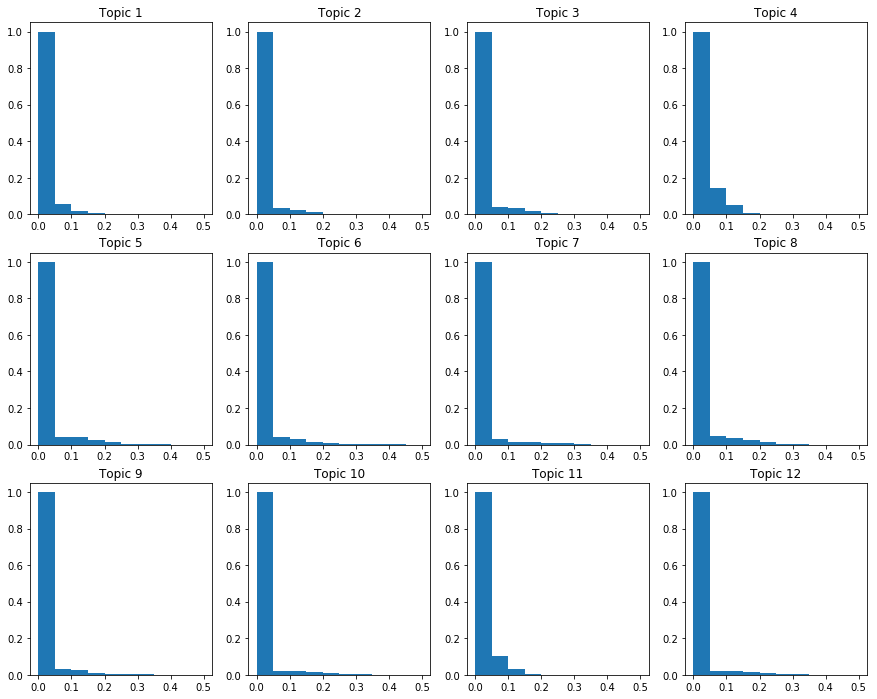

In [24]:
n_topics = 12
model = decomposition.NMF( init="nndsvd", n_components=n_topics ) 
W = model.fit_transform(tfidf_v)
H = model.components_

# print the topics
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ", ".join([str(x) for x in idx_to_word[topic.argsort()[-20:]]])))

plt.rcParams['figure.figsize'] = (15.0, 12.0)

plt.subplot(3, 4, 1)
plt.hist(W[:,0], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 1')

plt.subplot(3, 4, 2)
plt.hist(W[:,1], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 2')

plt.subplot(3, 4, 3)
plt.hist(W[:,2], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 3')

plt.subplot(3, 4, 4)
plt.hist(W[:,3], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 4')

plt.subplot(3, 4, 5)
plt.hist(W[:,4], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 5')

plt.subplot(3, 4, 6)
plt.hist(W[:,5], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 6')

plt.subplot(3, 4, 7)
plt.hist(W[:,6], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 7')

plt.subplot(3, 4, 8)
plt.hist(W[:,7], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 8')

plt.subplot(3, 4, 9)
plt.hist(W[:,8], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 9')

plt.subplot(3, 4, 10)
plt.hist(W[:,9], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 10')

plt.subplot(3, 4, 11)
plt.hist(W[:,10], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 11')

plt.subplot(3, 4, 12)
plt.hist(W[:,11], bins=10, density=True, histtype='stepfilled', cumulative=-1, range=(0.0,0.5))
plt.title('Topic 12')

plt.show()

We display the word cloud of each of the 12 clusters below.

270


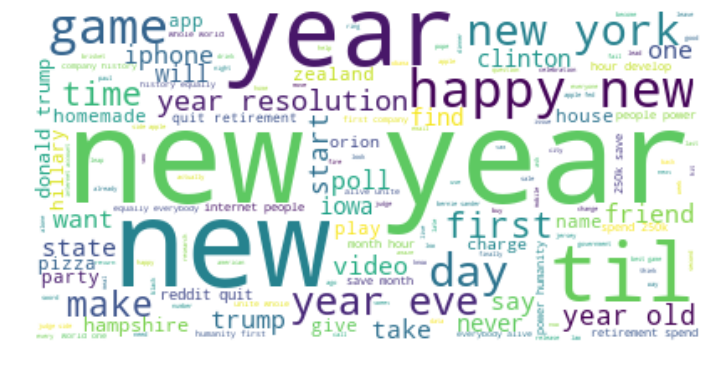

In [25]:
top_indices1 = np.argsort(W[:,0])[::-1]
top_documents1 = []
topic1_str = ''
for doc_index in top_indices1[0:n_doc]:
    if W[doc_index,0] > 0.05:
        top_documents1.append(reddit_newcorpus[doc_index])
        topic1_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents1))
top_documents1

plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic1_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

182


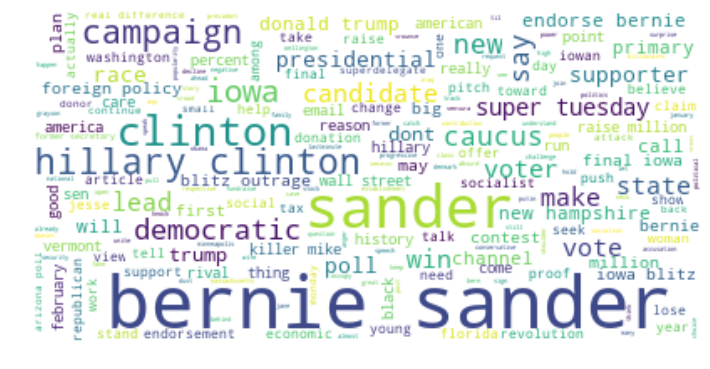

In [26]:
top_indices2 = np.argsort(W[:,1])[::-1]
top_documents2 = []
topic2_str = ''
for doc_index in top_indices2[0:n_doc]:
    if W[doc_index,1] > 0.05:
        top_documents2.append(reddit_newcorpus[doc_index])
        topic2_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents2))
top_documents2
plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic2_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

187


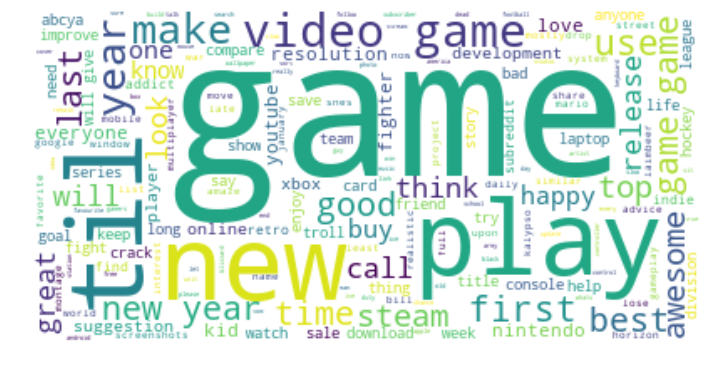

In [27]:
top_indices3 = np.argsort(W[:,2])[::-1]
top_documents3 = []
topic3_str = ''
for doc_index in top_indices3[0:n_doc]:
    if W[doc_index,2] > 0.05:
        top_documents3.append(reddit_newcorpus[doc_index])
        topic3_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents3))
top_documents3

plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic3_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

693


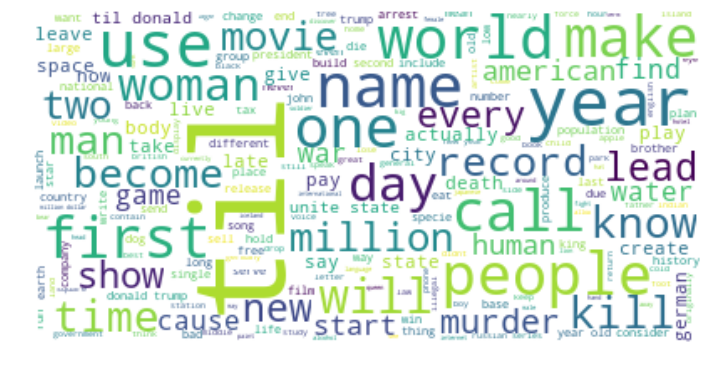

In [28]:
top_indices4 = np.argsort(W[:,3])[::-1]
top_documents4 = []
topic4_str = ''
for doc_index in top_indices4[0:n_doc]:
    if W[doc_index,3] > 0.05:
        top_documents4.append(reddit_newcorpus[doc_index])
        topic4_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents4))
top_documents4

plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic4_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

206


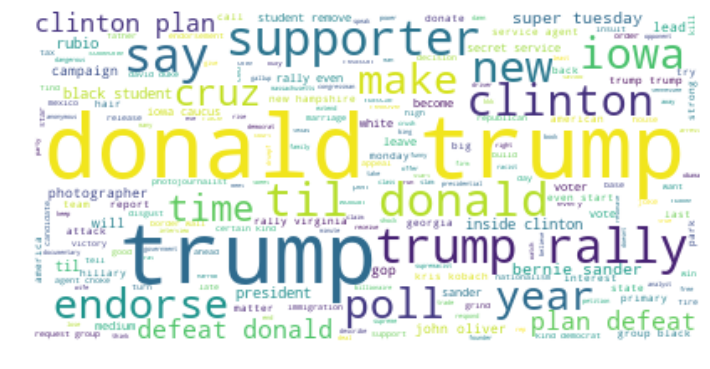

In [29]:
top_indices5 = np.argsort(W[:,4])[::-1]
top_documents5 = []
topic5_str = ''
for doc_index in top_indices5[0:n_doc]:
    if W[doc_index,4] > 0.05:
        top_documents5.append(reddit_newcorpus[doc_index])
        topic5_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents5))
top_documents5

plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic5_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

204


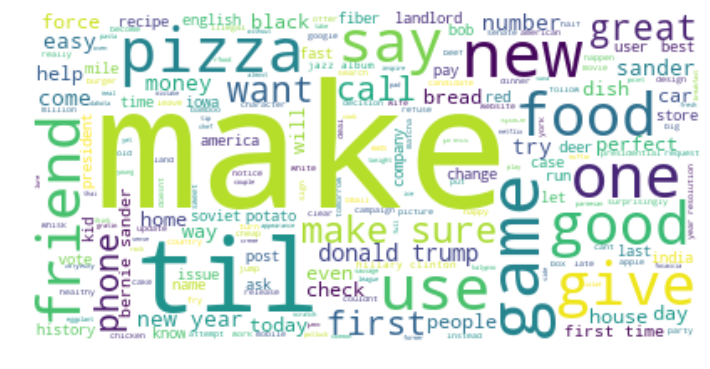

In [30]:
top_indices6 = np.argsort(W[:,5])[::-1]
top_documents6 = []
topic6_str = ''
for doc_index in top_indices6[0:n_doc]:
    if W[doc_index,5] > 0.05:
        top_documents6.append(reddit_newcorpus[doc_index])
        topic6_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents6))
top_documents6

plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic6_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

146


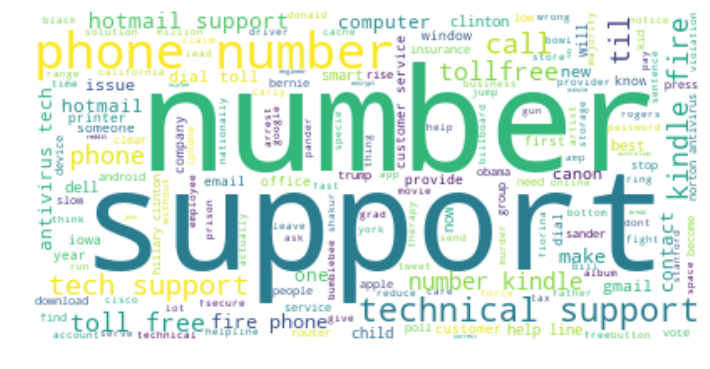

In [31]:
top_indices7 = np.argsort(W[:,6])[::-1]
top_documents7 = []
topic7_str = ''
for doc_index in top_indices7[0:n_doc]:
    if W[doc_index,6] > 0.05:
        top_documents7.append(reddit_newcorpus[doc_index])
        topic7_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents7))
top_documents7

plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic7_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

229


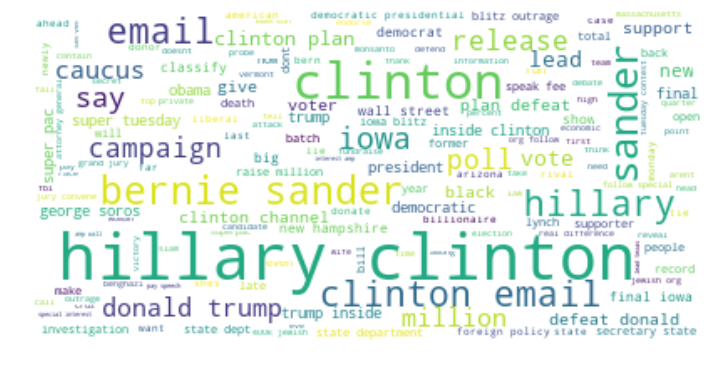

In [32]:
top_indices8 = np.argsort(W[:,7])[::-1]
top_documents8 = []
topic8_str = ''
for doc_index in top_indices8[0:n_doc]:
    if W[doc_index,7] > 0.05:
        top_documents8.append(reddit_newcorpus[doc_index])
        topic8_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents8))
top_documents8

plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic8_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

165


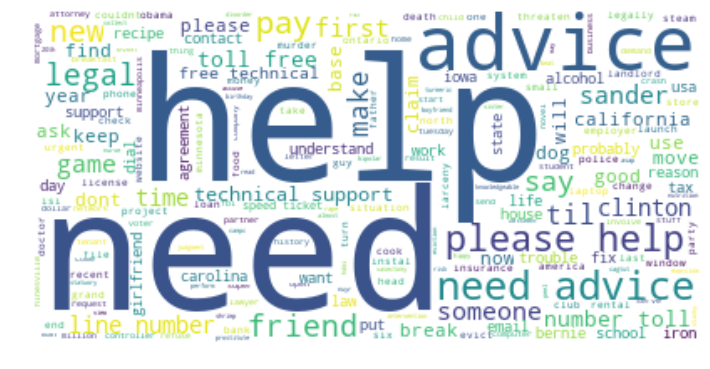

In [33]:
top_indices9 = np.argsort(W[:,8])[::-1]
top_documents9 = []
topic9_str = ''
for doc_index in top_indices9[0:n_doc]:
    if W[doc_index,8] > 0.05:
        top_documents9.append(reddit_newcorpus[doc_index])
        topic9_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents9))
top_documents9

plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic9_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

109


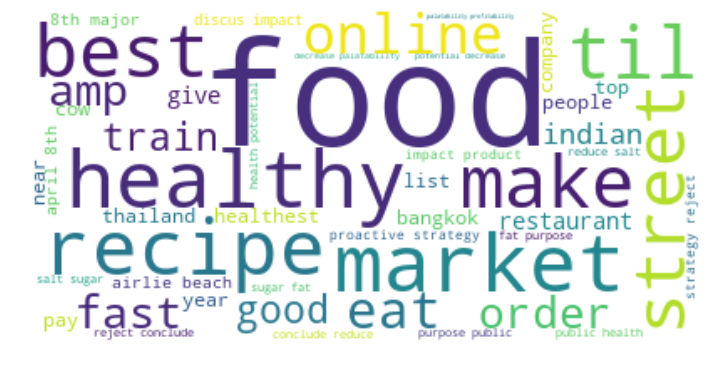

In [34]:
top_indices10 = np.argsort(W[:,9])[::-1]
top_documents10 = []
topic10_str = ''
for doc_index in top_indices10[0:n_doc]:
    if W[doc_index,9] > 0.05:
        top_documents10.append(reddit_newcorpus[doc_index])
        topic10_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents10))
top_documents10

plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic10_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

510


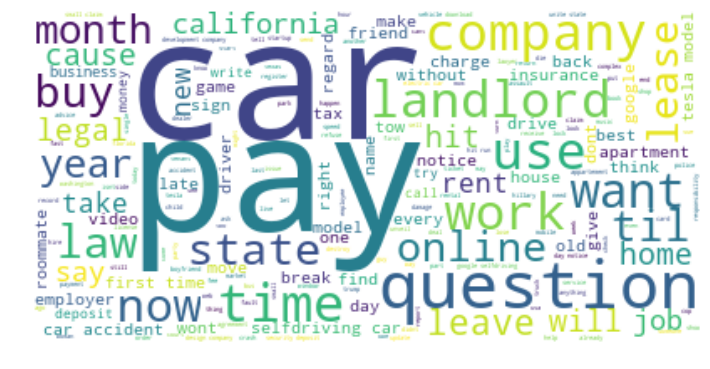

In [35]:
top_indices11 = np.argsort(W[:,10])[::-1]
top_documents11 = []
topic11_str = ''
for doc_index in top_indices11[0:n_doc]:
    if W[doc_index,10] > 0.05:
        top_documents11.append(reddit_newcorpus[doc_index])
        topic11_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents11))
top_documents11

plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic11_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

107


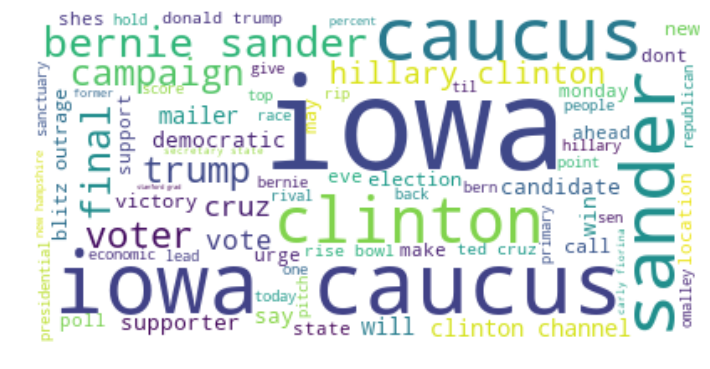

In [36]:
top_indices12 = np.argsort(W[:,11])[::-1]
top_documents12 = []
topic12_str = ''
for doc_index in top_indices12[0:n_doc]:
    if W[doc_index,11] > 0.05:
        top_documents12.append(reddit_newcorpus[doc_index])
        topic12_str += ' ' + lemmatized_reddit_corpus[doc_index]
print(len(top_documents12))
top_documents12

plt.rcParams['figure.figsize'] = (12.0, 8.0)

wordcloud = WordCloud(background_color="white").generate(topic12_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We also look at the titles that were not classified under any of the 12 clusters above.

In [37]:
unclustered_ind = []
for ind in range(4895):
    if np.amax(W[ind,:]) <= 0.05:
        unclustered_ind.append(ind)
unclustered_titles = [reddit_newcorpus[i] for i in unclustered_ind]
print(len(unclustered_titles))
unclustered_titles

2413


['7 interesting hidden features of apple ios9',
 'semi automatic ropp capping machine / ropp cap sealing machine',
 'microsoft plumbs ocean’s depths to test underwater data center',
 'stewed ramps w/ fixings in helvatia, wv',
 '(california) is it a crime when a religious figure/ lecturer has relations with one of his followers',
 'being accused of public indecency, among other things. this is a misunderstanding because i had health issues. [kansas, usa]',
 'sf/nyc what is the best way to find a good startup lawyer?',
 'littlebigplanet 3 recreates uncharted 4 trailer',
 'how cod kills your hope',
 'test',
 'kentucky senate oks requiring ultrasounds prior to abortions',
 'socialshare page 1',
 'aussie heroes steam group',
 "i know this isn't tr best place to talk about this but i'll try. what is your opinion on black ops 3?",
 '15 tips to boost your productivity',
 "ted cruz's super pac has printed up fake newspapers about him",
 'my dad died yesterday and my mom is now being evicted bec

The original 7 clusters also appeared in the new clustering implementation, but now we were able to separate Bernie Sanders from Hillary Clinton. In addition, we have new clusters involving asking help or advice, food, question on paying, and Iowa.

Since we still have 2435 titles left unclustered, perhaps increasing the number of clusters will help identify the topics in the unclustered list.

### Conclusions and Recommendations

The NMF factorization is a good way to classify the reddit titles into different topics. Increasing the number of maximum clusters does not destroy the original clusters created when one uses fewer clusters. The drawback of the method is the fact that one title can be included into more than one cluster, or it could be left as unclustered.

When we set the number of clusters to $k=7$, we obtain the following clusters:
1. New Year
2. Sanders, Clinton
3. Game
4. TIL (Today I Learned)
5. Trump
6. Make
7. Support
When we set the number of clusters to $k=12$, the following clusters emerge:
1. New Year
2. Sanders
3. Game
4. TIL (Today I Learned)
5. Trump
6. Make
7. Support
8. Clinton
9. Need Help/Advice
10. Food
11. Question, Pay, Car
12. Iowa

One could find the optimal number of clusters so that all of the titles in the file `reddit-dmw-sample.txt` can be classified. One could also play around with the criteria to say that a certain title belongs in a particular cluster.

### References

* Reddit - Wikipedia (accessed from https://en.wikipedia.org/wiki/Reddit)
* Why do you prefer reddit over other social medias? : AskReddit (accessed from https://www.reddit.com/r/AskReddit/comments/b2h34d/why_do_you_prefer_reddit_over_other_social_medias/)
* Lemmatization Approaches with Examples in Python (accessed from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)
* Feature Extraction (accessed from https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
* A Practical Introduction to NMF (nonnegative matrix factorization) (accessed from https://mlexplained.com/2017/12/28/a-practical-introduction-to-nmf-nonnegative-matrix-factorization/)
* (Greene, Derek) Topic Modeling with Scikit-learn (accessed from https://github.com/derekgreene/topic-model-tutorial)
* Generating WordClouds in Python (accessed from https://www.datacamp.com/community/tutorials/wordcloud-python)
* tf-idf - Wikipedia (accessed from https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
* (Dy, Anthony Brian and Teodosio, Marlon) Subtopics in News Articles about Artificial Intelligence in the Last 30 Days
* (Gupta, Vishal and Lehal, Gurpreet) A Survey of Text Mining Techniques and Applications, Journal of Emerging Technologies in Web Intelligence, Vol. 1, No. 1, August 2009
* (Kim, Jungu, Kuang, Da and He, Yunlong) Nonnegative Matrix Factorization for Clustering (accessed from https://web.stanford.edu/group/mmds/slides2012/s-park.pdf?fbclid=IwAR0BLxuvufM7R0srUBqTZALeEenmnPOlcJPWeV0T4BT8ZdyZsDAYsiSJsp8)
* Information Retrieval and Searching by Similarity Part I

### Acknowledgements

The author would like to thank Nigel Silva and Dustin Reyes for their significant input on how to go about with the clustering methods.